# Evaluate Age and Gender VGGFace Models on Juul Faces

### Imports

In [3]:
import torch
import pickle
import sys, os

import importlib

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
project_dir = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
if not project_dir in sys.path: sys.path.append(project_dir)

In [5]:
train_utils = importlib.import_module('src.age_gender.train_utils', project_dir)
plot = importlib.import_module('src.rgutils.plot', project_dir)
utils = importlib.import_module('src.utils', project_dir)

In [6]:
%load_ext autoreload

%autoreload 2

In [7]:
device = torch.device('cuda')

### Predict ages and gender

In [8]:
!ls -l ../models/age_gender/

total 921280
-rw-rw-r-- 1 neuro neuro 94363911 Aug  6 23:38 vgg_age_cv0.hdf
-rw-rw-r-- 1 neuro neuro 94363911 Aug  6 23:38 vgg_age_cv1.hdf
-rw-rw-r-- 1 neuro neuro 94363911 Aug  6 23:38 vgg_age_cv2.hdf
-rw-rw-r-- 1 neuro neuro 94363911 Aug  6 23:38 vgg_age_cv3.hdf
-rw-rw-r-- 1 neuro neuro 94363911 Aug  6 23:38 vgg_age_cv4.hdf
-rw-rw-r-- 1 neuro neuro 94306551 Aug  7 09:46 vgg_gender_cv0.hdf
-rw-rw-r-- 1 neuro neuro 94306551 Aug  7 09:46 vgg_gender_cv1.hdf
-rw-rw-r-- 1 neuro neuro 94306559 Aug  7 09:47 vgg_gender_cv2.hdf
-rw-rw-r-- 1 neuro neuro 94306563 Aug  7 09:47 vgg_gender_cv3.hdf
-rw-rw-r-- 1 neuro neuro 94306619 Aug  7 09:47 vgg_gender_cv4.hdf


##### Load models

In [9]:
vggface_weights = '../models/external/resnet50_ft_weight.pkl'
age_model_path = '../models/age_gender/vgg_age_cv{index}.hdf'
gender_model_path = '../models/age_gender/vgg_gender_cv{index}.hdf'

num_folds = 5
age_classes = 8
gender_classes = 1

In [10]:
vggface = train_utils.load_vggface_model('resnet', project_dir, vggface_weights)
vggface.cuda()
indices = list(range(num_folds))

In [11]:
age_cv = {}
for i in indices:
    path = age_model_path.format(index = i)
    age_net = train_utils.create_model(vggface, age_classes, device,)
    age_net.load_state_dict(torch.load(path))
    age_net.eval()
    age_cv[i] = age_net
    print(f'Loaded {path}')

Loaded ../models/age_gender/vgg_age_cv0.hdf
Loaded ../models/age_gender/vgg_age_cv1.hdf
Loaded ../models/age_gender/vgg_age_cv2.hdf
Loaded ../models/age_gender/vgg_age_cv3.hdf
Loaded ../models/age_gender/vgg_age_cv4.hdf


In [12]:
gender_cv = {}

for i in indices:
    path = gender_model_path.format(index = i)
    gender_net = train_utils.create_model(vggface, gender_classes, device,)
    gender_net.load_state_dict(torch.load(path))
    gender_net.eval()
    gender_cv[i] = gender_net
    print(f'Loaded {path}')

Loaded ../models/age_gender/vgg_gender_cv0.hdf
Loaded ../models/age_gender/vgg_gender_cv1.hdf
Loaded ../models/age_gender/vgg_gender_cv2.hdf
Loaded ../models/age_gender/vgg_gender_cv3.hdf
Loaded ../models/age_gender/vgg_gender_cv4.hdf


##### Juul Face Loader

In [13]:
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2



class JuulDataset(Dataset):
    def __init__(self, face_detections, face_clusters, model_input_size,
                 input_transforms=None):
        image_paths = utils.load_hdf(face_detections, keys=['image_paths'])['image_paths']
        clusters = np.load(face_clusters)
        assert len(image_paths) == len(clusters)
        # select only clustered images
        self.image_paths = image_paths[clusters > 0]
        self.image_paths = [p.decode('utf-8') for p in self.image_paths]
        self.clusters = clusters[clusters > 0]
        self.model_input_size = model_input_size
        self.input_transforms = input_transforms
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        cluster = self.clusters[idx]
        img = train_utils.load_convert_resize(image_path, self.model_input_size)
        if self.input_transforms:
            img = self.input_transforms(img)
        return img, cluster

In [16]:
juul_faces_detections = '../data/interim/embeddings/test_env_mtcnn.hdf5'
juul_faces_clusters = '../data/interim/clusters/test_env.npy'


juul_faces = JuulDataset(juul_faces_detections, juul_faces_clusters, (224,224))

len(juul_faces)

1281

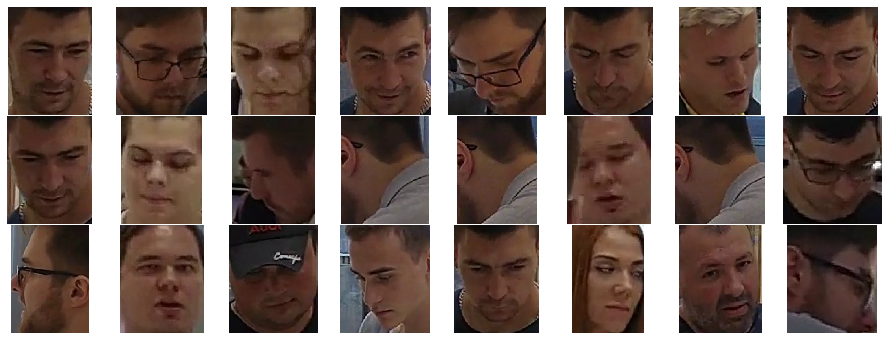

In [17]:
plot.show_images(juul_faces.image_paths, 3,8, fig_dims=(16,6))

##### Make predictions

In [18]:
from torchvision import transforms
from tqdm import tqdm

In [19]:
BATCH_SIZE = 64
num_jobs = 4

In [20]:
img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.45, 0.44, 0.49], [0.25, 0.22, 0.24]),
])

In [21]:
juul_faces = JuulDataset(juul_faces_detections, juul_faces_clusters, (224,224), 
                         input_transforms=img_transforms)

In [22]:
juul_loader = DataLoader(juul_faces, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_jobs)

In [23]:
for x,y in juul_loader: break

x.size(), x.mean(), y.size()

(torch.Size([64, 3, 224, 224]), tensor(-0.9982), torch.Size([64]))

In [24]:
age_predictions = torch.zeros(len(juul_faces), len(age_cv), device=device)
gender_predictions = torch.zeros(len(juul_faces), len(gender_cv), device=device)
batch_num = 0
with torch.no_grad():
    for x,y in tqdm(juul_loader, desc='Batches'):
        start = batch_num * BATCH_SIZE
        end = min((batch_num + 1) * BATCH_SIZE, len(juul_faces))
        # predict ages
        for i,age_model in age_cv.items():
            age_out = age_model(x.cuda())
            _,y_pred_age = torch.max(age_out, dim=1)
            age_predictions[start:end, i] = y_pred_age
        # predict genders
        for i,gender_model in gender_cv.items():
            gender_out = gender_model(x.cuda())
            y_pred_gender = torch.sigmoid(torch.squeeze(gender_out, dim=1)) > 0.5
            gender_predictions[start:end, i] = y_pred_gender
        batch_num += 1
    

Batches: 100%|██████████| 21/21 [01:30<00:00,  2.69s/it]


##### Decode predictions

In [25]:
from collections import Counter

In [26]:
age_vals =  ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', 
            '(38, 43)', '(48, 53)', '(60, 100)']
age_decoded = {v:k for v,k in enumerate(age_vals)}

gender_vals = ['f', 'm']
gender_decoded = {v:k for v,k in enumerate(gender_vals)}

In [27]:
get_age_fn = lambda x: Counter([age_decoded[int_label] for int_label in list(x.cpu().numpy())])
get_gender_fn = lambda x: Counter([gender_decoded[int_label] for int_label in list(x.cpu().numpy())])

predicted_ages = list(map(get_age_fn, age_predictions))

predicted_gender = list(map(get_gender_fn, gender_predictions))

In [28]:
image_paths = np.array(juul_faces.image_paths)
image_clusters = np.array(juul_faces.clusters)
predicted_ages = np.array(predicted_ages)
predicted_gender = np.array(predicted_gender)

##### Visualize predicted ages

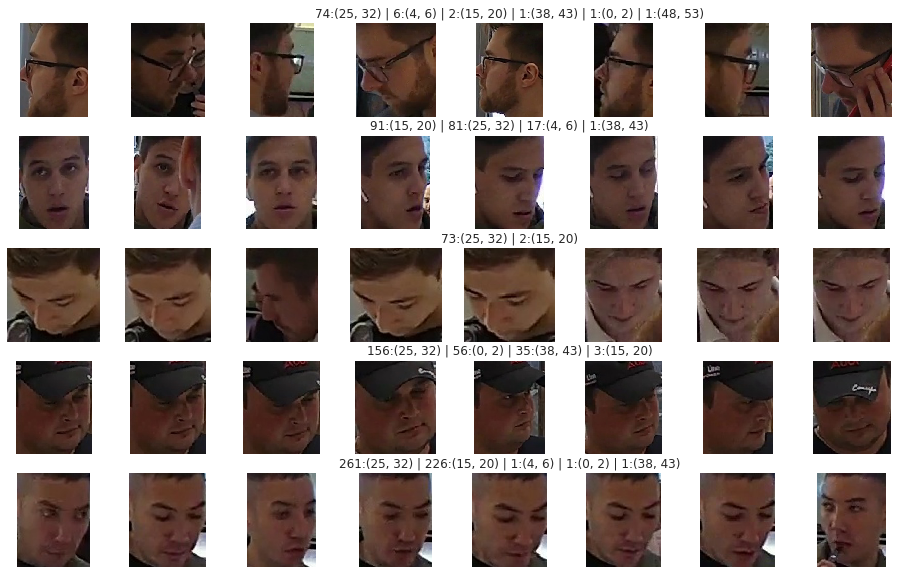

In [29]:
individual_title = False

n_row, n_col = 5, 8
fig,axes = plt.subplots(n_row, n_col, squeeze=False, figsize=(n_col*2, n_row*2))
_ = [a.axis('off') for a in axes.ravel()]

for r in range(n_row):
    clust = np.random.choice(np.unique(juul_faces.clusters))
    cluster_images = image_paths[image_clusters == clust]
    cluster_labels = predicted_ages[image_clusters == clust]
    num_show = min(n_col, len(cluster_images))
    indices = np.random.choice(len(cluster_images), size=num_show)
    for c,ind in enumerate(indices):
        img = plt.imread(cluster_images[ind])
        axes[r,c].imshow(img)
        if individual_title:
            mc = cluster_labels[ind].most_common()
            title = [f'{cnt}:{lab}' for lab,cnt in mc]
            title = ' | '.join(title)
            axes[r,c].set_title(title)
        else:
            if c == num_show // 2:
                label_counter = Counter()
                _ = [label_counter.update(mc) for mc in cluster_labels] 
                title = [f'{cnt}:{lab}' for lab,cnt in label_counter.most_common()]
                title = ' | '.join(title)
                axes[r,c].set_title(title)
        
plt.show()

##### Visualize predicted Gender

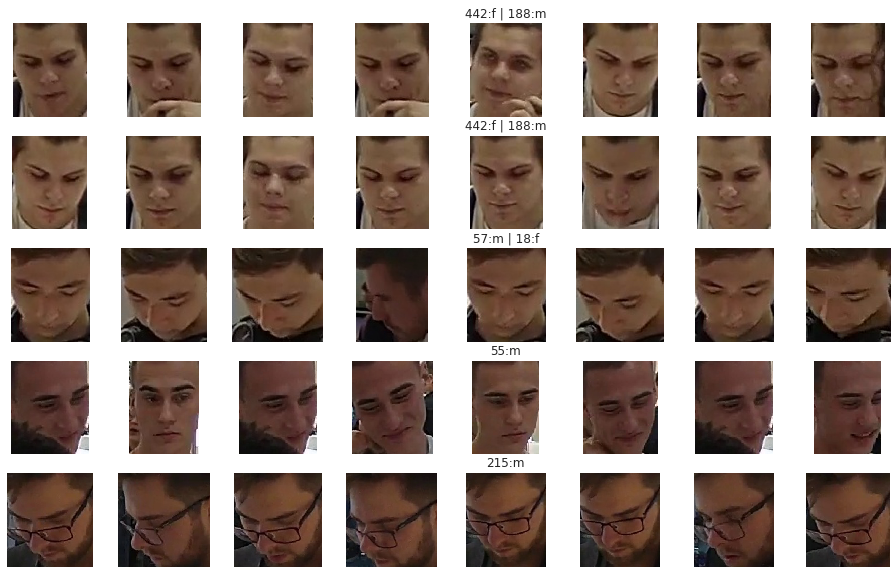

In [34]:
individual_title = False

n_row, n_col = 5, 8
fig,axes = plt.subplots(n_row, n_col, squeeze=False, figsize=(n_col*2, n_row*2))
_ = [a.axis('off') for a in axes.ravel()]

for r in range(n_row):
    clust = np.random.choice(np.unique(juul_faces.clusters))
    cluster_images = image_paths[image_clusters == clust]
    cluster_labels = predicted_gender[image_clusters == clust]
    num_show = min(n_col, len(cluster_images))
    indices = np.random.choice(len(cluster_images), size=num_show)
    for c,ind in enumerate(indices):
        img = plt.imread(cluster_images[ind])
        axes[r,c].imshow(img)
        if individual_title:
            mc = cluster_labels[ind].most_common()
            title = [f'{cnt}:{lab}' for lab,cnt in mc]
            title = ' | '.join(title)
            axes[r,c].set_title(title)
        else:
            if c == num_show // 2:
                label_counter = Counter()
                _ = [label_counter.update(mc) for mc in cluster_labels] 
                title = [f'{cnt}:{lab}' for lab,cnt in label_counter.most_common()]
                title = ' | '.join(title)
                axes[r,c].set_title(title)
        
plt.show()